In [38]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error

In [3]:
!curl https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv -o housing.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1390k  100 1390k    0     0  3466k      0 --:--:-- --:--:-- --:--:-- 3466k


In [4]:
df = pd.read_csv('housing.csv')

In [5]:
selected_cols = [
    'latitude',
    'longitude',
    'housing_median_age',
    'total_rooms',
    'total_bedrooms',
    'population',
    'households',
    'median_income',
    'median_house_value',
    'ocean_proximity',
]
df = df[selected_cols]

In [6]:
df.isnull().sum()

latitude                0
longitude               0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [7]:
df = df.fillna(0)
df.isnull().sum()

latitude              0
longitude             0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

In [8]:
df['rooms_per_household'] = df['total_rooms'] / df['households']
df['bedrooms_per_room'] = df['total_bedrooms'] / df['total_rooms']
df['population_per_household'] = df['population'] / df['households']

In [9]:
'''
Question 1

What is the most frequent observation (mode) for the column ocean_proximity?
'''
df['ocean_proximity'].value_counts()
#df['ocean_proximity'].mode()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

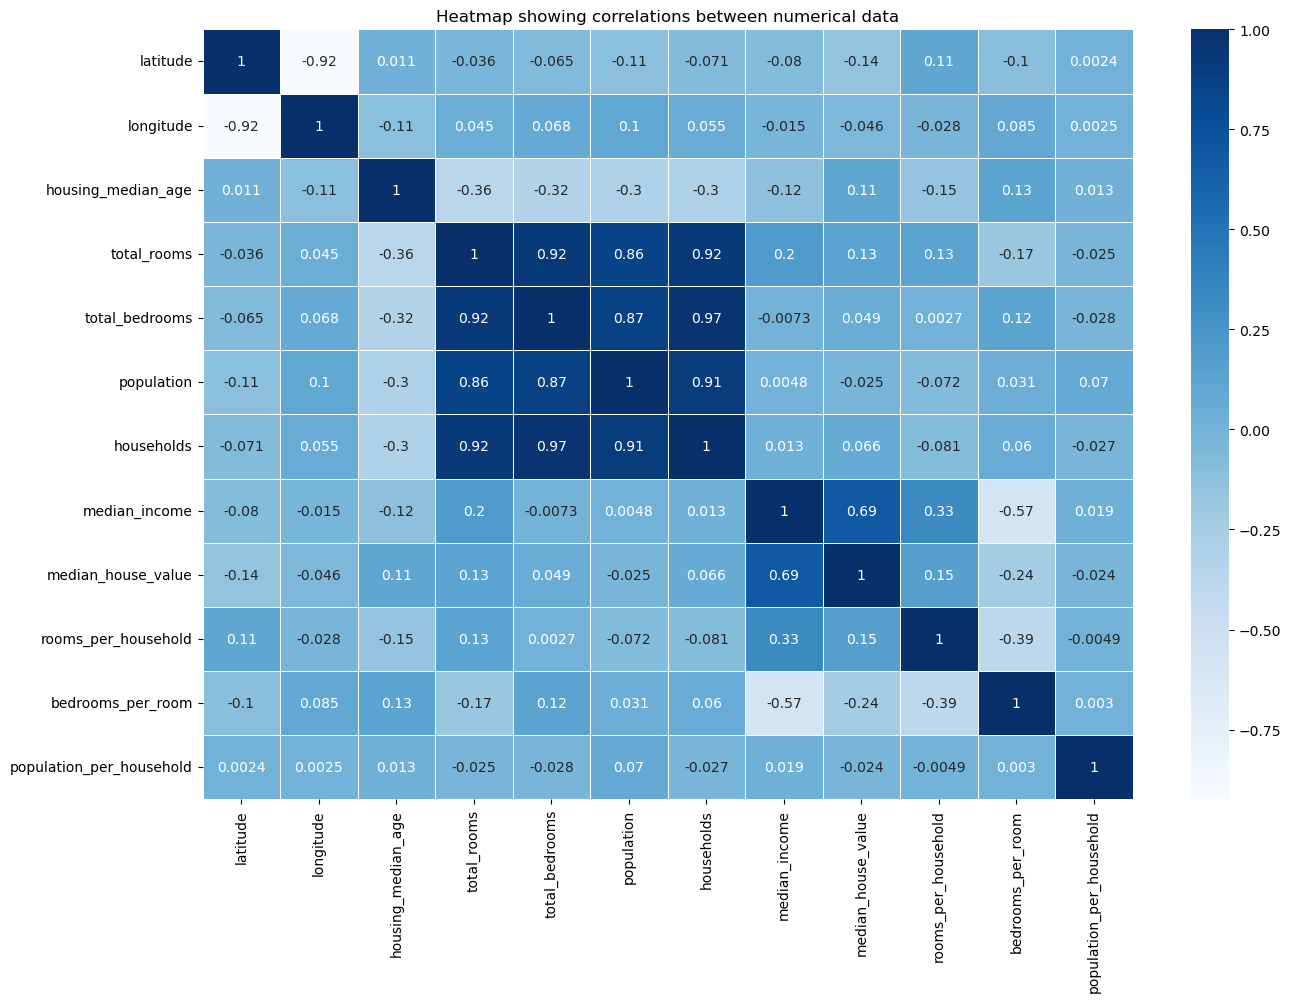

In [11]:
'''
Question 2

    Create the correlation matrix for the numerical features of your train dataset.
        In a correlation matrix, you compute the correlation coefficient between every pair of features in the dataset.
    What are the two features that have the biggest correlation in this dataset?
'''

correlation_matrix = df.corr()
correlation_matrix[correlation_matrix < 1].max()
correlation_matrix[correlation_matrix < 1].unstack().sort_values(ascending=False).drop_duplicates()
#@ INSPECTING HEATMAP:
plt.figure(figsize=(15,10))  
sns.heatmap(correlation_matrix,annot=True,linewidths=.5, cmap="Blues")
plt.title('Heatmap showing correlations between numerical data')
plt.show()

In [12]:
df['above_average'] = (df['median_house_value'] > df['median_house_value'].mean()).astype(int)

In [13]:
print(df['median_house_value'].mean())
df[['median_house_value','above_average']].iloc[:20]

206855.81690891474


,median_house_value,above_average
0,452600.0,1
1,358500.0,1
2,352100.0,1
3,341300.0,1
4,342200.0,1
5,269700.0,1
6,299200.0,1
7,241400.0,1
8,226700.0,1
9,261100.0,1


In [14]:
df = df.drop('median_house_value', axis=1)
y = df.pop('above_average')
df_train_val, df_test, y_train_val, y_test = train_test_split(df, y, test_size=0.20, random_state=42)
df_train, df_val, y_train, y_val = train_test_split(df_train_val, y_train_val, test_size=0.25, random_state=42)

In [16]:
'''
Question 3

    Calculate the mutual information score between above_average and ocean_proximity . Use the training set only.
    Round it to 2 decimals using round(score, 2)
    What is their mutual information score?
'''
round(mutual_info_score(y_train, df_train['ocean_proximity']),2)

0.1

In [31]:
'''
Question 4

    Now let's train a logistic regression
    Remember that we have one categorical variable ocean_proximity in the data. Include it using one-hot encoding.
    Fit the model on the training dataset.
        To make sure the results are reproducible across different versions of Scikit-Learn, fit the model with these parameters:
        model = LogisticRegression(solver="liblinear", C=1.0, max_iter=1000, random_state=42)
    Calculate the accuracy on the validation dataset and round it to 2 decimal digits.
'''
dv = DictVectorizer(sparse=False)
df_train_dict = df_train.to_dict(orient='records')
dv.fit(df_train_dict)
x_train = dv.transform(df_train_dict)
#dv.get_feature_names()
model = LogisticRegression(solver="liblinear", C=1.0, max_iter=1000, random_state=42)
model.fit(x_train, y_train)

LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')

In [32]:
df_val_dict = df_val.to_dict(orient='records')
x_val = dv.transform(df_val_dict)
y_val_pred = model.predict(x_val)
val_accuracy = (y_val_pred == y_val).mean()
round(val_accuracy,2)
original_accuracy_score = accuracy_score(y_val_pred, y_val)
round(accuracy_score(y_val_pred, y_val),2)

0.84

In [34]:
'''
Question 5

    Let's find the least useful feature using the feature elimination technique.
    Train a model with all these features (using the same parameters as in Q4).
    Now exclude each feature from this set and train a model without it. Record the accuracy for each model.
    For each feature, calculate the difference between the original accuracy and the accuracy without the feature.
    Which of following feature has the smallest difference?
        total_rooms
        total_bedrooms
        population
        households

Note: the difference doesn't have to be positive
'''
features_to_check = ['total_rooms', 'total_bedrooms', 'population', 'households']

for feature in df_train.columns.values.tolist():
    features = df_train.columns.values.tolist()
    features.remove(feature)
    dv = DictVectorizer(sparse=False)
    df_train_dict = df_train[features].to_dict(orient='records')
    dv.fit(df_train_dict)
    x_train = dv.transform(df_train_dict)
    model = LogisticRegression(solver="liblinear", C=1.0, max_iter=1000, random_state=42)
    model.fit(x_train, y_train)
    df_val_dict = df_val[features].to_dict(orient='records')
    x_val = dv.transform(df_val_dict)
    y_val_pred = model.predict(x_val)
    val_accuracy = (y_val_pred == y_val).mean()
    print(feature, 
          abs(original_accuracy_score - accuracy_score(y_val_pred, y_val)), 
          round(accuracy_score(y_val_pred, y_val),2))

latitude 0.002422480620155043 0.83
longitude 0.0009689922480620172 0.84
housing_median_age 0.005329457364341095 0.83
total_rooms 0.0014534883720930258 0.84
total_bedrooms 0.00024224806201555982 0.84
population 0.009689922480620172 0.83
households 0.002664728682170492 0.83
median_income 0.05087209302325579 0.79
ocean_proximity 0.0169573643410853 0.82
rooms_per_household 0.0004844961240310086 0.84
bedrooms_per_room 0.00024224806201555982 0.84
population_per_household 0.0007267441860465684 0.84


In [40]:
'''
Question 6

    For this question, we'll see how to use a linear regression model from Scikit-Learn
    We'll need to use the original column 'median_house_value'. Apply the logarithmic transformation to this column.
    Fit the Ridge regression model (model = Ridge(alpha=a, solver="sag", random_state=42)) on the training data.
    This model has a parameter alpha. Let's try the following values: [0, 0.01, 0.1, 1, 10]
    Which of these alphas leads to the best RMSE on the validation set? Round your RMSE scores to 3 decimal digits.
'''
a_list = [0, 0.01, 0.1, 1, 10]


df = pd.read_csv('housing.csv')
df = df[selected_cols]

y = df.pop('median_house_value')
y = np.log1p(y)
df_train_val, df_test, y_train_val, y_test = train_test_split(df, y, test_size=0.20, random_state=42)
df_train, df_val, y_train, y_val = train_test_split(df_train_val, y_train_val, test_size=0.25, random_state=42)


dv = DictVectorizer(sparse=False)
df_train_dict = df_train.to_dict(orient='records')
dv.fit(df_train_dict)
x_train = dv.transform(df_train_dict)
df_val_dict = df_val.to_dict(orient='records')
x_val = dv.transform(df_val_dict)

for a in a_list:
    model = Ridge(alpha=a, solver="sag", random_state=42)
    model.fit(x_train, y_train)
    y_val_pred = model.predict(x_val)
    print(a, round(mean_squared_error(y_val_pred, y_val),3))

0 0.275
0.01 0.275
0.1 0.275
1 0.275
10 0.275
